In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("merged.csv")

In [3]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'TBL', 'fraction_genome_altered', 'aneuploidy_score', 'TMB', 'msi_status']
x = data.drop(columns=columns_to_drop)
x_encoded = pd.get_dummies(x)
y = data['msi_status']

In [4]:
#create the train,test and validation set
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, train_size =0.8, test_size=0.2, random_state =42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)

In [5]:
#Decision trees
tree = DecisionTreeClassifier()

tree.fit(x_train, y_train)
#predict with validation set
y_predicted_validation = tree.predict(x_validation)
validation_accuracy = accuracy_score(y_validation, y_predicted_validation)
print("Validation Accuracy:", validation_accuracy)

Validation Accuracy: 0.7011494252873564


In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=1)  
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)


# Print the shape of the resampled data 
print("Shape of original training data:", x_train.shape, y_train.shape)
print("Shape of oversampled training data:", x_train_resampled.shape, y_train_resampled.shape)

# Train the decision tree classifier on the oversampled data
tree_oversampled = DecisionTreeClassifier()
tree_oversampled.fit(x_train_resampled, y_train_resampled)

Shape of original training data: (261, 9439) (261,)
Shape of oversampled training data: (516, 9439) (516,)


DecisionTreeClassifier()

In [7]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameters to tune
param_distributions = {
    'criterion': ['gini'],
    'max_depth': [1,2,3,4,5,6,7,8,9,10,15,None],
    'min_samples_split': [2,5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt']
}

# Randomized search for best hyperparameters
randomized_search = RandomizedSearchCV(estimator=tree_oversampled, param_distributions=param_distributions, n_iter=5, cv=5, scoring='accuracy')
randomized_search.fit(x_train_resampled, y_train_resampled)

# Print best parameters and best score
print("Best parameters:", randomized_search.best_params_)
# Get the best hyperparameters
best_params = randomized_search.best_params_

Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'gini'}


In [8]:
# Create a decision tree classifier with the best parameters
best_tree_classifier = DecisionTreeClassifier(**best_params)

# Train the model with the best parameters on the entire training data (including oversampled data)
best_tree_classifier.fit(x_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=25, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10)

In [9]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with the best parameters
cross_val_scores = cross_val_score(best_tree_classifier, x_train_resampled, y_train_resampled, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)

# Calculate the mean cross-validation score
mean_cv_score = cross_val_scores.mean()
print("Mean Cross-Validation Score:", mean_cv_score)

Cross-Validation Scores: [0.69230769 0.66019417 0.83495146 0.7961165  0.83495146]
Mean Cross-Validation Score: 0.7637042569081405


In [10]:
# Predict on the test set
y_predicted_test = best_tree_classifier.predict(x_test)
test_accuracy = accuracy_score(y_test, y_predicted_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.5747126436781609


In [ ]:
from sklearn.tree import plot_tree
# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_decision = plot_tree(best_tree_classifier, feature_names=x_encoded.columns, class_names=best_tree_classifier.classes_, filled=True, fontsize=5)
# Adjust layout to ensure all elements are within the visible area
plt.tight_layout()

# Save the plot as an image file
#plt.savefig('decision_tree_plot.png', dpi=300)

# Show the plot
plt.show()

Confusion Matrix:
 [[ 8  1  4]
 [ 1  2 11]
 [ 6 14 40]]


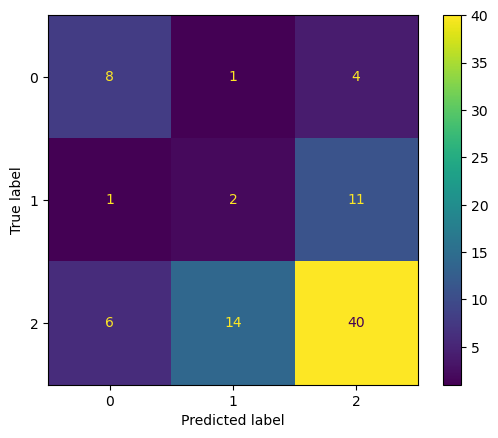

In [11]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_predicted_test)
print("Confusion Matrix:\n", conf_matrix)
conf_mx = metrics.confusion_matrix(y_test, y_predicted_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mx)
cm_display.plot()
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize

# Convert the true labels and predicted labels to binary format for each class
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_predicted_test_binarized = label_binarize(y_predicted_test, classes=np.unique(y_test))

from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_predicted_test_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_predicted_test_binarized.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(np.unique(y_test)))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(np.unique(y_test))):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(np.unique(y_test))
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='purple', lw=2, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})')
plt.plot(fpr_macro, tpr_macro, color='navy', lw=2, linestyle='--', label=f'Macro-average ROC curve (AUC = {roc_auc_macro:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc='lower right')
# Save the ROC plot as an image file
plt.savefig('roc_plot.png', dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import classification_report


print(f"Best Decision Tree Accuracy: {test_accuracy:.2f}")
print(f"Best Hyperparameters: {best_params}")
print("Classification report for Decision Tree after randomized search on test set")
print("Accuracy: ", metrics.accuracy_score(y_test, y_predicted_test))

# Generate classification report
report = classification_report(y_test, y_predicted_test)

# Print the classification report
print("Classification Report:")
print(report)
print(metrics.confusion_matrix(y_test, y_predicted_test))

Top 10 Features:
      Feature  Importance
7763  FAM217B    0.195607
7229   ADGRG6    0.166925
1785     NKD1    0.049824
3772    CEBPB    0.042258
1388    GNG12    0.035235
2752   SEC61B    0.030051
7315   CITED2    0.030033
3340     RBL2    0.028916
915     CLDN2    0.028778
3847    PADI2    0.028652


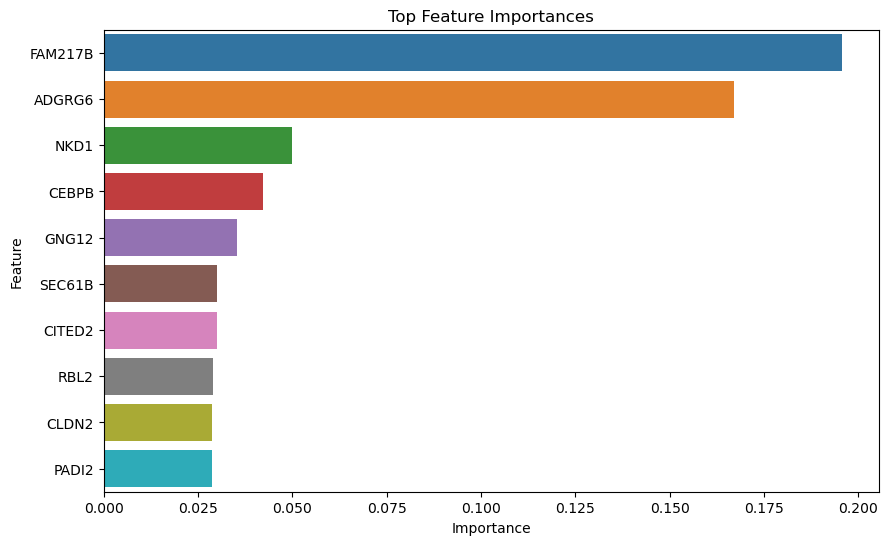

In [12]:
# Get feature importances from the trained decision tree classifier
feature_importances = best_tree_classifier.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': x_encoded.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top n features and their importances
n = 10  
print(f"Top {n} Features:")
print(feature_importance_df.head(n))

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(n))
plt.title('Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()